# ORF recognition by Convolutional/Recurrent

So far CNN+LSTM 64 overfits the 128 base RNA problem.
That was using 32K samples/class. Here, try more samples. 

Also, build the model without specifying INPUT_SIZE.



In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-24 18:59:13 UTC'

In [2]:
PC_SEQUENCES=32000   # how many protein-coding sequences
NC_SEQUENCES=32000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=128            # how long is each sequence
CDS_LEN=64            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 16   # how many different patterns the model looks for
CELLS = 16
NEURONS = 16
DROP_RATE = 0.4
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=25  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    from RNA_describe import Random_Base_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import prepare_inputs_len_x_alphabet
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter,Random_Base_Oracle
        from SimTools.RNA_prep import prepare_inputs_len_x_alphabet

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login


On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
rbo=Random_Base_Oracle(RNA_LEN,True)
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,10) # just testing
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 34 trials to reach 10 per class.
It took 130537 trials to reach 33000 per class.
Use 33000 PC seqs
Use 33000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 128.0
Average ORF length: 81.08827272727272
NC seqs
Average RNA length: 128.0
Average ORF length: 28.612909090909092


In [7]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [8]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [9]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(MaxPooling1D())
    #dnn.add(TimeDistributed(Flatten()))
    dnn.add(LSTM(CELLS,return_sequences=True))
    dnn.add(LSTM(CELLS,return_sequences=False))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    #dnn.build(input_shape=INPUT_SHAPE)   
    dnn.build()   
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (128, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 16)           208       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 16)           784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 16)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64, 16)            2112      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dropout (Dropout)        

In [10]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (128, 4)
FIT
Epoch 1/25
1334/1334 [==============================] - 34s 12ms/step - loss: 0.6984 - accuracy: 0.5054 - val_loss: 0.6851 - val_accuracy: 0.5557


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/25
1334/1334 [==============================] - 14s 10ms/step - loss: 0.6796 - accuracy: 0.5679 - val_loss: 0.6558 - val_accuracy: 0.6136


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/25
1334/1334 [==============================] - 14s 11ms/step - loss: 0.6489 - accuracy: 0.6251 - val_loss: 0.6325 - val_accuracy: 0.6410


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/25
1334/1334 [==============================] - 14s 11ms/step - loss: 0.6359 - accuracy: 0.6401 - val_loss: 0.6164 - val_accuracy: 0.6559


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/25
1334/1334 [==============================] - 14s 10ms/step - loss: 0.6235 - accuracy: 0.6498 - val_loss: 0.6083 - val_accuracy: 0.6620


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/25
1334/1334 [==============================] - 14s 10ms/step - loss: 0.6025 - accuracy: 0.6725 - val_loss: 0.5936 - val_accuracy: 0.6827


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 7/25
1334/1334 [==============================] - 14s 11ms/step - loss: 0.5846 - accuracy: 0.6877 - val_loss: 0.5742 - val_accuracy: 0.6938


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 8/25
1334/1334 [==============================] - 14s 10ms/step - loss: 0.5736 - accuracy: 0.6962 - val_loss: 0.5678 - val_accuracy: 0.6932
Epoch 9/25
1334/1334 [==============================] - 14s 11ms/step - loss: 0.5758 - accuracy: 0.6913 - val_loss: 0.5651 - val_accuracy: 0.6942


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 10/25
1334/1334 [==============================] - 14s 11ms/step - loss: 0.5694 - accuracy: 0.6965 - val_loss: 0.5636 - val_accuracy: 0.6951


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 11/25
1334/1334 [==============================] - 14s 10ms/step - loss: 0.5673 - accuracy: 0.6980 - val_loss: 0.5645 - val_accuracy: 0.6991


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 12/25
1334/1334 [==============================] - 14s 11ms/step - loss: 0.5670 - accuracy: 0.6995 - val_loss: 0.5591 - val_accuracy: 0.6964
Epoch 13/25
1334/1334 [==============================] - 14s 10ms/step - loss: 0.5666 - accuracy: 0.6965 - val_loss: 0.5627 - val_accuracy: 0.6891
Epoch 14/25
1334/1334 [==============================] - 14s 11ms/step - loss: 0.5627 - accuracy: 0.6992 - val_loss: 0.5639 - val_accuracy: 0.6904
Epoch 15/25
1334/1334 [==============================] - 14s 10ms/step - loss: 0.5612 - accuracy: 0.6991 - val_loss: 0.5609 - val_accuracy: 0.6937
Epoch 16/25
1334/1334 [==============================] - 14s 11ms/step - loss: 0.5607 - accuracy: 0.7009 - val_loss: 0.5803 - val_accuracy: 0.6811
Epoch 17/25
1334/1334 [==============================] - 14s 11ms/step - loss: 0.5631 - accuracy: 0.6989 - val_loss: 0.5612 - val_accuracy: 0.6962
Epoch 18/25
1334/1334 [==============================] - 14s 11ms/step - loss: 0.5608 - accuracy: 0.7025 - val_loss: 0

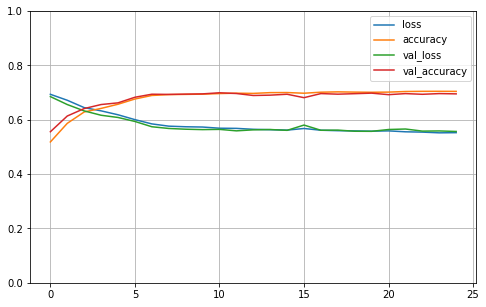

MODEL
make_DNN
input shape: (128, 4)
FIT
Epoch 1/25
1334/1334 [==============================] - 18s 11ms/step - loss: 0.7142 - accuracy: 0.5045 - val_loss: 0.6872 - val_accuracy: 0.5472
Epoch 2/25
1334/1334 [==============================] - 14s 10ms/step - loss: 0.6863 - accuracy: 0.5478 - val_loss: 0.6623 - val_accuracy: 0.6020
Epoch 3/25
1334/1334 [==============================] - 14s 10ms/step - loss: 0.6630 - accuracy: 0.6017 - val_loss: 0.6369 - val_accuracy: 0.6360
Epoch 4/25
1334/1334 [==============================] - 14s 10ms/step - loss: 0.6398 - accuracy: 0.6337 - val_loss: 0.6314 - val_accuracy: 0.6450
Epoch 5/25
1334/1334 [==============================] - 14s 11ms/step - loss: 0.6317 - accuracy: 0.6456 - val_loss: 0.6240 - val_accuracy: 0.6504
Epoch 6/25
1334/1334 [==============================] - 14s 11ms/step - loss: 0.6114 - accuracy: 0.6659 - val_loss: 0.5833 - val_accuracy: 0.6865
Epoch 7/25
1334/1334 [==============================] - 14s 10ms/step - loss: 0.589

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 20/25
1334/1334 [==============================] - 14s 10ms/step - loss: 0.5597 - accuracy: 0.7005 - val_loss: 0.5598 - val_accuracy: 0.6984
Epoch 21/25
1334/1334 [==============================] - 14s 10ms/step - loss: 0.5623 - accuracy: 0.7040 - val_loss: 0.5557 - val_accuracy: 0.7007


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 22/25
1334/1334 [==============================] - 14s 11ms/step - loss: 0.5586 - accuracy: 0.7011 - val_loss: 0.5606 - val_accuracy: 0.6995
Epoch 23/25
1334/1334 [==============================] - 14s 10ms/step - loss: 0.5540 - accuracy: 0.7032 - val_loss: 0.5540 - val_accuracy: 0.6999
Epoch 24/25
1334/1334 [==============================] - 14s 10ms/step - loss: 0.5548 - accuracy: 0.7034 - val_loss: 0.5898 - val_accuracy: 0.6664
Epoch 25/25
1334/1334 [==============================] - 14s 11ms/step - loss: 0.5601 - accuracy: 0.7008 - val_loss: 0.5578 - val_accuracy: 0.6983
Fold 2, 25 epochs, 371 sec


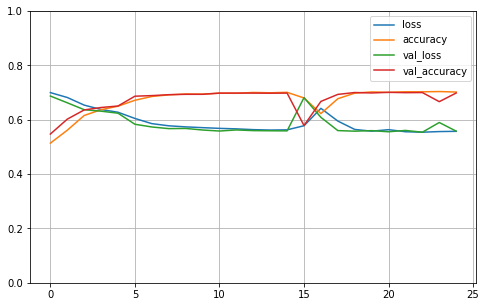

MODEL
make_DNN
input shape: (128, 4)
FIT
Epoch 1/25
1334/1334 [==============================] - 18s 12ms/step - loss: 0.7016 - accuracy: 0.5252 - val_loss: 0.6573 - val_accuracy: 0.6083
Epoch 2/25
1334/1334 [==============================] - 14s 10ms/step - loss: 0.6572 - accuracy: 0.6055 - val_loss: 0.6307 - val_accuracy: 0.6426
Epoch 3/25
1334/1334 [==============================] - 14s 11ms/step - loss: 0.6355 - accuracy: 0.6422 - val_loss: 0.6426 - val_accuracy: 0.6264
Epoch 4/25
1334/1334 [==============================] - 14s 10ms/step - loss: 0.6218 - accuracy: 0.6590 - val_loss: 0.6162 - val_accuracy: 0.6582
Epoch 5/25
1334/1334 [==============================] - 14s 11ms/step - loss: 0.6051 - accuracy: 0.6714 - val_loss: 0.5960 - val_accuracy: 0.6705
Epoch 6/25
1334/1334 [==============================] - 14s 10ms/step - loss: 0.5894 - accuracy: 0.6863 - val_loss: 0.5809 - val_accuracy: 0.6855
Epoch 7/25
1334/1334 [==============================] - 14s 11ms/step - loss: 0.580

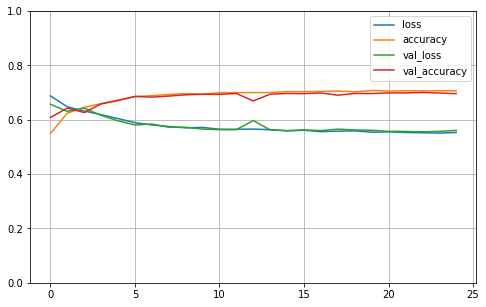

In [11]:
do_cross_validation(X,y)

In [12]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 68.30%


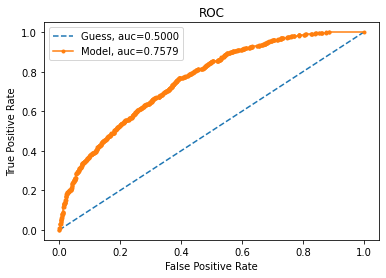

AUC: 75.79%


In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [14]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-24 19:19:18 UTC'